# In this project we will analyize all Italian restaurants in Toronto
# to select good location to open new one.


# Author : Aljawharah Alareefi

In [3]:
# isntall libraries 
!pip install geocoder
!pip install folium

     |████████████████████████████████| 98 kB 7.0 MB/s  eta 0:00:01
     |████████████████████████████████| 93 kB 3.5 MB/s  eta 0:00:01


# Import Libraries

In [4]:
import numpy as np # library to handle data in a vectorized manner
import pandas as pd # library for data analsysis
import requests 
import urllib.request # import the library we use to open URLs
from bs4 import BeautifulSoup  #library for scrape  the web pages
import folium 
from geopy.geocoders import Nominatim 
import geocoder
from pandas.io.json import json_normalize
import matplotlib.pyplot as plt
%matplotlib inline 
import matplotlib.cm as cm
import matplotlib.colors as colors

print('Libraries imported.')

Libraries imported.


# We scrape the Wikipedia page using Python, Urllib, Beautiful Soup and Pandas

In [5]:
url = 'https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M'

# open the url using urllib.request and put the HTML into the page variable
page = urllib.request.urlopen(url)
soup = BeautifulSoup(page, "lxml")

#After parsing the html page we found the table with class wikitable sortable
torronto_table=soup.find('table', class_='wikitable sortable')

# Loop through the rows and store values into 3 list : A for postal code , B for Borough and C for Neighborhood
A=[]
B=[]
C=[]

for row in torronto_table.findAll('tr'):
    cells=row.findAll('td')
    if len(cells)==3:
        A.append(cells[0].find(text=True))
        B.append(cells[1].find(text=True))
        C.append(cells[2].find(text=True))

# Convert Lists to data frame
df_torronto = pd.DataFrame(A,columns=['PostalCode'])
df_torronto['Borough']=B
df_torronto['Neighborhood']=C
df_torronto.head()        

,PostalCode,Borough,Neighborhood
0,M1A\n,Not assigned\n,Not assigned\n
1,M2A\n,Not assigned\n,Not assigned\n
2,M3A\n,North York\n,Parkwoods\n
3,M4A\n,North York\n,Victoria Village\n
4,M5A\n,Downtown Toronto\n,"Regent Park, Harbourfront\n"


# Data Cleansing

In [6]:

#remove \n 
df_torronto['PostalCode'] = df_torronto['PostalCode'].replace('\n','', regex=True)
df_torronto['Borough'] = df_torronto['Borough'].replace('\n','', regex=True)
df_torronto['Neighborhood'] = df_torronto['Neighborhood'].replace('\n','', regex=True)
df_torronto.head()


,PostalCode,Borough,Neighborhood
0,M1A,Not assigned,Not assigned
1,M2A,Not assigned,Not assigned
2,M3A,North York,Parkwoods
3,M4A,North York,Victoria Village
4,M5A,Downtown Toronto,"Regent Park, Harbourfront"


In [7]:
#drop rows with "Not Assigned" value and reindex and print the shap
df_torronto.drop(df_torronto[df_torronto['Borough'] == 'Not assigned'].index, axis = 0, inplace = True)
df_torronto.reset_index(drop=True).head()
print(df_torronto.shape)
df_torronto.head()

(103, 3)


,PostalCode,Borough,Neighborhood
2,M3A,North York,Parkwoods
3,M4A,North York,Victoria Village
4,M5A,Downtown Toronto,"Regent Park, Harbourfront"
5,M6A,North York,"Lawrence Manor, Lawrence Heights"
6,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government"


# Read latitude and the longitude coordinates of each neighborhood.

In [8]:
geo_ll = pd.read_csv('http://cocl.us/Geospatial_data')
geo_ll.head()

,Postal Code,Latitude,Longitude
0,M1B,43.806686,-79.194353
1,M1C,43.784535,-79.160497
2,M1E,43.763573,-79.188711
3,M1G,43.770992,-79.216917
4,M1H,43.773136,-79.239476


In [9]:
# Rename postal code column to match data frame column 
geo_ll.rename(columns={'Postal Code':'PostalCode'},inplace=True)
# Then merg to tables
geo_data = pd.merge(df_torronto, geo_ll, on='PostalCode')
geo_data.head()

,PostalCode,Borough,Neighborhood,Latitude,Longitude
0,M3A,North York,Parkwoods,43.753259,-79.329656
1,M4A,North York,Victoria Village,43.725882,-79.315572
2,M5A,Downtown Toronto,"Regent Park, Harbourfront",43.654260,-79.360636
3,M6A,North York,"Lawrence Manor, Lawrence Heights",43.718518,-79.464763
4,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government",43.662301,-79.389494


# Exploratory Data Analysis

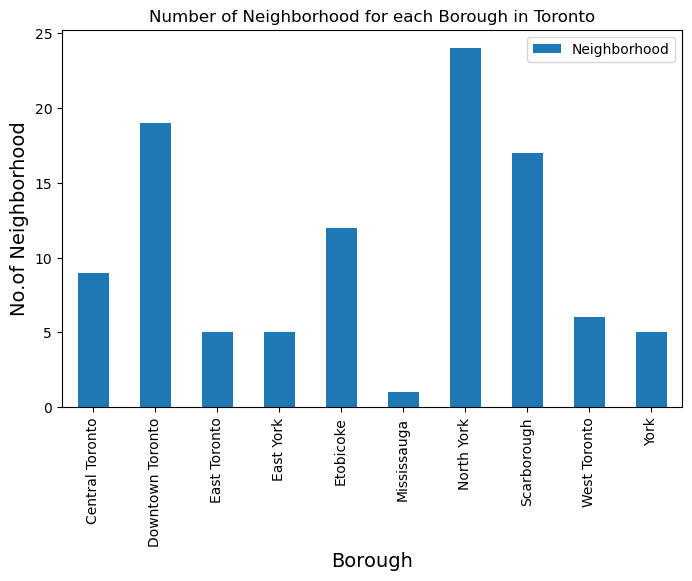

In [10]:
plt.figure(figsize=(8,5), dpi = 100)
# title
plt.title('Number of Neighborhood for each Borough in Toronto')
#On x-axis
plt.xlabel('Borough', fontsize = 14)
#On y-axis
plt.ylabel('No.of Neighborhood', fontsize=14)
#giving a bar plot
geo_data.groupby('Borough')['Neighborhood'].count().plot(kind='bar')
#legend
plt.legend()
#displays the plot
plt.show()

In [11]:
#Take address and return lat and long
def geo_location(address):
    # get geo location of address
    geolocator = Nominatim(user_agent="my_explorer")
    location = geolocator.geocode(address)
    latitude = location.latitude
    longitude = location.longitude
    return latitude,longitude

In [60]:
# Take lat and lng and return all venues around the this location  
def get_venues(lat,lng):
    
    #set variables
    radius=1000
    LIMIT=100
    CLIENT_ID = '20NE2WZLGXA1JX4H4WRNJS04OJNYVRB3T01KJSBUNJOLV1RI' # your Foursquare ID
    CLIENT_SECRET = 'A3QWL2FWTABRTGVR3ZXRXR1DZQ4XPQDEPAGTRAT5EN1DCYYV' # your Foursquare Secret
    VERSION = '20180605' # Foursquare API version
    
    #url to fetch data from foursquare api
    url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
    
    # get all the data
    results = requests.get(url).json()
    venue_data=results["response"]['groups'][0]['items']
    venue_details=[]
    for row in venue_data:
        try:
            venue_id=row['venue']['id']
            venue_name=row['venue']['name']
            venue_category=row['venue']['categories'][0]['name']
            venue_details.append([venue_id,venue_name,venue_category])
        except KeyError:
            pass
        
    column_names=['ID','Name','Category']
    df = pd.DataFrame(venue_details,columns=column_names)
    return df

In [61]:
# The total neighborhood list which contains Italian restaurants in Toronto City
column_names=['Borough', 'Neighborhood', 'ID','Name']
Italian_rest_toronto=pd.DataFrame(columns=column_names)
count=1
for row in geo_data.values.tolist():
    Postalcode, Borough, Neighborhood, Latitude, Longitude=row
    venues = get_venues(Latitude,Longitude)
    Italian_restaurants=venues[venues['Category']=='Italian Restaurant']   
    print('(',count,'/',len(geo_data),')','Italian Restaurants in '+Neighborhood+', '+Borough+':'+str(len(Italian_restaurants)))
    for restaurant_detail in Italian_restaurants.values.tolist():
        id, name , category=restaurant_detail
        Italian_rest_toronto = Italian_rest_toronto.append({'Borough': Borough,
                                                'Neighborhood': Neighborhood, 
                                                'ID': id,
                                                'Name' : name
                                               }, ignore_index=True)
    count+=1

( 1 / 103 ) Italian Restaurants in Parkwoods, North York:0
( 2 / 103 ) Italian Restaurants in Victoria Village, North York:0
( 3 / 103 ) Italian Restaurants in Regent Park, Harbourfront, Downtown Toronto:4
( 4 / 103 ) Italian Restaurants in Lawrence Manor, Lawrence Heights, North York:0
( 5 / 103 ) Italian Restaurants in Queen's Park, Ontario Provincial Government, Downtown Toronto:3
( 6 / 103 ) Italian Restaurants in Islington Avenue, Humber Valley Village, Etobicoke:0
( 7 / 103 ) Italian Restaurants in Malvern, Rouge, Scarborough:0
( 8 / 103 ) Italian Restaurants in Don Mills, North York:0
( 9 / 103 ) Italian Restaurants in Parkview Hill, Woodbine Gardens, East York:0
( 10 / 103 ) Italian Restaurants in Garden District, Ryerson, Downtown Toronto:2
( 11 / 103 ) Italian Restaurants in Glencairn, North York:2
( 12 / 103 ) Italian Restaurants in West Deane Park, Princess Gardens, Martin Grove, Islington, Cloverdale, Etobicoke:0
( 13 / 103 ) Italian Restaurants in Rouge Hill, Port Union, 

( 103 / 103 ) Italian Restaurants in Mimico NW, The Queensway West, South of Bloor, Kingsway Park South West, Royal York South West, Etobicoke:2


In [14]:
Italian_rest_toronto.head(10)

,Borough,Neighborhood,ID,Name
0,Downtown Toronto,"Regent Park, Harbourfront",4ad776eef964a520e20a21e3,Mangia and Bevi Resto-Bar
1,Downtown Toronto,"Regent Park, Harbourfront",4cbdc6784495721ea262617a,Fusaro's
2,Downtown Toronto,"Regent Park, Harbourfront",4ac3e6cef964a520629d20e3,Archeo
3,Downtown Toronto,"Regent Park, Harbourfront",56d8dff7498eb4e5e661e78d,Ardo
4,Downtown Toronto,"Queen's Park, Ontario Provincial Government",4a8355bff964a520d3fa1fe3,Mercatto
5,Downtown Toronto,"Queen's Park, Ontario Provincial Government",5a69ba9112138476a91996f8,Dal Moro's Fresh Pasta To Go
6,Downtown Toronto,"Queen's Park, Ontario Provincial Government",4af30f13f964a52030ea21e3,Trattoria Nervosa
7,Downtown Toronto,"Garden District, Ryerson",4cbdc6784495721ea262617a,Fusaro's
8,Downtown Toronto,"Garden District, Ryerson",4a8355bff964a520d3fa1fe3,Mercatto
9,North York,Glencairn,4e0f938d7d8bb178a8b434f8,Sala Caboto


In [15]:
#Total Italian Restaurant in Toronto City 

Italian_rest_toronto.shape


(108, 4)

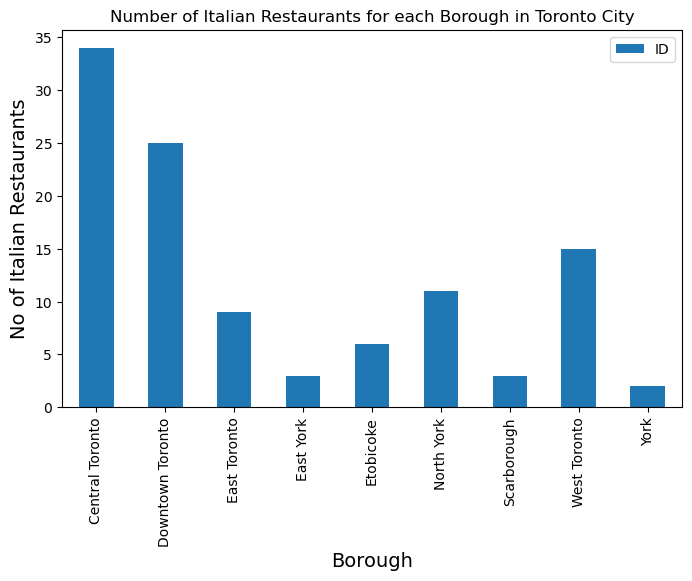

In [16]:
# To know the maximum no of Italian Restaurant in each Borough we will plot the data grouping by Borough
plt.figure(figsize=(8,5), dpi = 100)
# Title
plt.title('Number of Italian Restaurants for each Borough in Toronto City')
# x-axis
plt.xlabel('Borough', fontsize = 14)
# y-axis
plt.ylabel('No of Italian Restaurants', fontsize=14)
#Creating bar plot
Italian_rest_toronto.groupby('Borough')['ID'].count().plot(kind='bar')
#legend
plt.legend()
#displays the plot
plt.show()

<b>Central Toronto</b> Borough has max no of Italian Restuarant in Toronto City

In [17]:
Italian_rest_toronto.groupby('Borough')['ID'].count()

Borough
Central Toronto     34
Downtown Toronto    25
East Toronto         9
East York            3
Etobicoke            6
North York          11
Scarborough          3
West Toronto        15
York                 2
Name: ID, dtype: int64

<b>Central Toronto </b>  Borough has 34 Italian Restaurant followed by<b> Downtown Toronto</b> has 24 and <b>East Toronto </b> which has 9 Italian Restaurant where as <b>York </b> Borough has least Italian Restaurant preset its count is only 2 in Toronto City respectively.

In [18]:
## Now we will check top 5 Neighborhoods which has max no of Italian Restaurant present.
Toronto_top_5_Neighbor = Italian_rest_toronto.groupby('Neighborhood')['ID'].count().nlargest(5).to_frame(name='Total')
Toronto_top_5_Neighbor=Toronto_top_5_Neighbor.reset_index()
Toronto_top_5_Neighbor.rename(index=str, columns={"index": "Neighborhood", "Total": "Total Italian Restaurant"}, inplace=True)
Toronto_top_5_Neighbor

,Neighborhood,Total Italian Restaurant
0,Davisville,9
1,Davisville North,5
2,"The Annex, North Midtown, Yorkville",5
3,"Bedford Park, Lawrence Manor East",4
4,"Moore Park, Summerhill East",4


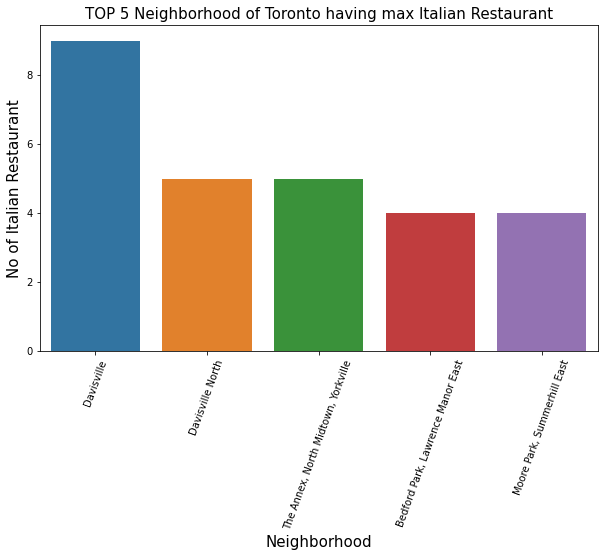

In [19]:
# We will Visualize the data in Bar Chart Graph
import seaborn as sns
fig = plt.figure(figsize=(10,6))
s=sns.barplot(x="Neighborhood", y="Total Italian Restaurant", data=Toronto_top_5_Neighbor)
s.set_xticklabels(s.get_xticklabels(), rotation=70)
plt.title('TOP 5 Neighborhood of Toronto having max Italian Restaurant', fontsize=15)
plt.xlabel("Neighborhood", fontsize=15)
plt.ylabel ("No of Italian Restaurant", fontsize=15)
plt.savefig("TOP_5_Neighborhood.png", dpi=300)
plt.show()

TOP 5 Neighborhood are selected
<b>Davisville</b> Neighborhoods has maximum no of Italian Restaurant with a count of 9 followed by <b>Davisville North</b> which has 5 Italian Restaurant each in Toronto City respectively.

In [21]:
## We will check in which Borough this neighborhoods falls under.
toronto_5_merge = Toronto_top_5_Neighbor.join(geo_data.set_index("Neighborhood"), on="Neighborhood")

print(toronto_5_merge.shape)
toronto_5_merge.head()

(5, 6)


,Neighborhood,Total Italian Restaurant,PostalCode,Borough,Latitude,Longitude
0,Davisville,9,M4S,Central Toronto,43.704324,-79.388790
1,Davisville North,5,M4P,Central Toronto,43.712751,-79.390197
2,"The Annex, North Midtown, Yorkville",5,M5R,Central Toronto,43.672710,-79.405678
3,"Bedford Park, Lawrence Manor East",4,M5M,North York,43.733283,-79.419750
4,"Moore Park, Summerhill East",4,M4T,Central Toronto,43.689574,-79.383160


In [25]:
 # create map of top 5 Neighborhood having Italian Restaurant using latitude and longitude values

# Get lat and long of Toronto
address = 'Toronto, Ontario, Canada'

geolocator = Nominatim(user_agent="to_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Torronto are {}, {}.'.format(latitude, longitude))


Toronto_5_topmap = folium.Map(location=[latitude, longitude], zoom_start=12)

# add markers to map
for lat, lng, label in zip(toronto_5_merge['Latitude'], toronto_5_merge['Longitude'], 
                           toronto_5_merge['Neighborhood']):
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=9,
        popup=label,
        color='magenta',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7).add_to(Toronto_5_topmap)  
    
Toronto_5_topmap

The geograpical coordinate of Torronto are 43.6534817, -79.3839347.


In [81]:

Italian_rest_toronto.groupby('Neighborhood').count()
Italian_rest_toronto.shape

(108, 4)

In [82]:
print('There are {} uniques Neighborhoods.'.format(len(Italian_rest_toronto['Neighborhood'].unique())))

There are 51 uniques Neighborhoods.


In [83]:

CLIENT_ID = '20NE2WZLGXA1JX4H4WRNJS04OJNYVRB3T01KJSBUNJOLV1RI' # your Foursquare ID
CLIENT_SECRET = 'A3QWL2FWTABRTGVR3ZXRXR1DZQ4XPQDEPAGTRAT5EN1DCYYV' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version
print('Credentials Stored')

Credentials Stored


In [84]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    LIMIT = 100 # limit of number of venues returned by Foursquare API
    radius = 500 # define radius
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
        
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [85]:

Toronto_Venues = getNearbyVenues(names=geo_data['Neighborhood'],
                                latitudes=geo_data['Latitude'],
                                longitudes=geo_data['Longitude'])

Parkwoods
Victoria Village
Regent Park, Harbourfront
Lawrence Manor, Lawrence Heights
Queen's Park, Ontario Provincial Government
Islington Avenue, Humber Valley Village
Malvern, Rouge
Don Mills
Parkview Hill, Woodbine Gardens
Garden District, Ryerson
Glencairn
West Deane Park, Princess Gardens, Martin Grove, Islington, Cloverdale
Rouge Hill, Port Union, Highland Creek
Don Mills
Woodbine Heights
St. James Town
Humewood-Cedarvale
Eringate, Bloordale Gardens, Old Burnhamthorpe, Markland Wood
Guildwood, Morningside, West Hill
The Beaches
Berczy Park
Caledonia-Fairbanks
Woburn
Leaside
Central Bay Street
Christie
Cedarbrae
Hillcrest Village
Bathurst Manor, Wilson Heights, Downsview North
Thorncliffe Park
Richmond, Adelaide, King
Dufferin, Dovercourt Village
Scarborough Village
Fairview, Henry Farm, Oriole
Northwood Park, York University
East Toronto, Broadview North (Old East York)
Harbourfront East, Union Station, Toronto Islands
Little Portugal, Trinity
Kennedy Park, Ionview, East Birchmo

In [86]:
Toronto_Venues.head()

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Parkwoods,43.753259,-79.329656,Brookbanks Park,43.751976,-79.332140,Park
1,Parkwoods,43.753259,-79.329656,Brookbanks Pool,43.751389,-79.332184,Pool
2,Parkwoods,43.753259,-79.329656,Variety Store,43.751974,-79.333114,Food & Drink Shop
3,Victoria Village,43.725882,-79.315572,Victoria Village Arena,43.723481,-79.315635,Hockey Arena
4,Victoria Village,43.725882,-79.315572,Portugril,43.725819,-79.312785,Portuguese Restaurant


In [87]:
# Check how many unique categories
print('There are {} uniques categories.'.format(len(Toronto_Venues['Venue Category'].unique())))

There are 267 uniques categories.


In [88]:
toronto_onehot = pd.get_dummies(Toronto_Venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
toronto_onehot['Neighborhoods'] = Toronto_Venues['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [toronto_onehot.columns[-1]] + list(toronto_onehot.columns[:-1])
toronto_onehot = toronto_onehot[fixed_columns]

print(toronto_onehot.shape)
toronto_onehot.head()

(2122, 268)


,Neighborhoods,Accessories Store,Adult Boutique,Afghan Restaurant,Airport,Airport Food Court,Airport Gate,Airport Lounge,Airport Service,Airport Terminal,...,Truck Stop,Turkish Restaurant,Vegetarian / Vegan Restaurant,Video Game Store,Vietnamese Restaurant,Warehouse Store,Wine Bar,Wings Joint,Women's Store,Yoga Studio
0,Parkwoods,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,Parkwoods,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,Parkwoods,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,Victoria Village,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,Victoria Village,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Let's group rows by neighborhood and by taking the mean of the frequency of occurrence of each category

In [89]:
toronto_grouped = toronto_onehot.groupby(["Neighborhoods"]).mean().reset_index()

print(toronto_grouped.shape)
toronto_grouped.head()

(96, 268)


,Neighborhoods,Accessories Store,Adult Boutique,Afghan Restaurant,Airport,Airport Food Court,Airport Gate,Airport Lounge,Airport Service,Airport Terminal,...,Truck Stop,Turkish Restaurant,Vegetarian / Vegan Restaurant,Video Game Store,Vietnamese Restaurant,Warehouse Store,Wine Bar,Wings Joint,Women's Store,Yoga Studio
0,Agincourt,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,"Alderwood, Long Branch",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,"Bathurst Manor, Wilson Heights, Downsview North",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,Bayview Village,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,"Bedford Park, Lawrence Manor East",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [91]:

# Now check in which neighborhood Italian Restuarant are present
Italian_res = toronto_grouped[["Neighborhoods","Italian Restaurant"]]
Italian_res = Italian_res.rename(columns={'Neighborhoods':'Neighborhood'})

Italian_res.head(10)

,Neighborhood,Italian Restaurant
0,Agincourt,0.000000
1,"Alderwood, Long Branch",0.000000
2,"Bathurst Manor, Wilson Heights, Downsview North",0.000000
3,Bayview Village,0.000000
4,"Bedford Park, Lawrence Manor East",0.130435
5,Berczy Park,0.000000
6,"Birch Cliff, Cliffside West",0.000000
7,"Brockton, Parkdale Village, Exhibition Place",0.043478
8,"Business reply mail Processing Centre, South C...",0.000000
9,"CN Tower, King and Spadina, Railway Lands, Har...",0.000000


# Clustering of the neighborhoods

In [94]:
## first import KMeans from sklearn
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=3, init='k-means++', max_iter=15, random_state=8)
X = Italian_res.drop(['Neighborhood'], axis=1)
kmeans.fit(X)
kmeans.labels_[0:30]

array([0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0,
       1, 0, 0, 0, 0, 0, 0, 0], dtype=int32)

In [95]:
def get_inertia(n_clusters):
    km = KMeans(n_clusters=n_clusters, init='k-means++', max_iter=15, random_state=8)
    km.fit(X)
    return km.inertia_

In [96]:
scores = [get_inertia(x) for x in range(2, 21)]

Text(0, 0.5, 'Error')

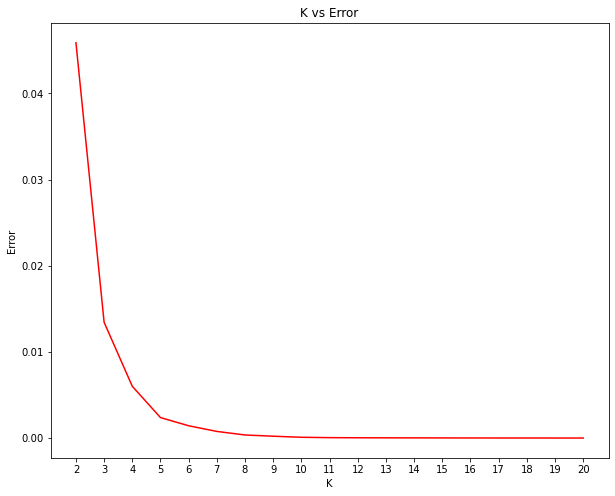

In [97]:

plt.figure(figsize=[10, 8])
sns.lineplot(x=range(2, 21), y=scores, color='r')
plt.title("K vs Error")
plt.xticks(range(2, 21))
plt.xlabel("K")
plt.ylabel("Error")

In [99]:
!pip install yellowbrick

     |████████████████████████████████| 269 kB 9.9 MB/s eta 0:00:01


In [100]:
from yellowbrick.cluster import KElbowVisualizer

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


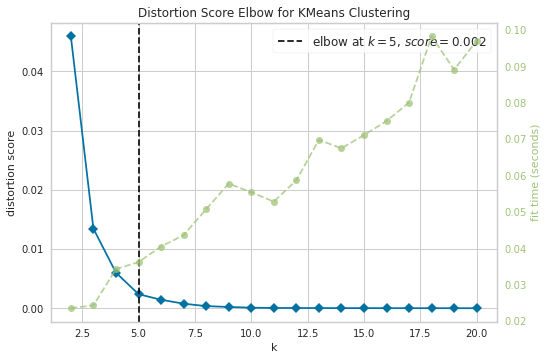

In [101]:
# Instantiate the clustering model and visualizer
model = KMeans()
visualizer = KElbowVisualizer(model, k=(2,21))

visualizer.fit(X)        # Fit the data to the visualizer
visualizer.show()

So we can see the optimum value of K is 5

In [102]:

kclusters = 5

tor_grouped_clustering = Italian_res.drop('Neighborhood', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(tor_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10]

array([0, 0, 0, 0, 4, 0, 0, 3, 0, 0], dtype=int32)

In [103]:
# create a new dataframe that includes the cluster as well as the top 10 venues for each neighborhood.
toronto_merged = Italian_res.copy()

# add clustering labels
toronto_merged["Cluster Labels"] = kmeans.labels_

In [104]:

toronto_merged.head()

,Neighborhood,Italian Restaurant,Cluster Labels
0,Agincourt,0.000000,0
1,"Alderwood, Long Branch",0.000000,0
2,"Bathurst Manor, Wilson Heights, Downsview North",0.000000,0
3,Bayview Village,0.000000,0
4,"Bedford Park, Lawrence Manor East",0.130435,4


In [105]:
# Now merge toronto grouped with previous toronto data to add latitude/longitude for each neighborhood
toronto_merged = toronto_merged.join(Toronto_Venues.set_index("Neighborhood"), on="Neighborhood")

print(toronto_merged.shape)
toronto_merged.head()

(2122, 9)


,Neighborhood,Italian Restaurant,Cluster Labels,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Agincourt,0.0,0,43.794200,-79.262029,Panagio's Breakfast & Lunch,43.792370,-79.260203,Breakfast Spot
0,Agincourt,0.0,0,43.794200,-79.262029,El Pulgarcito,43.792648,-79.259208,Latin American Restaurant
0,Agincourt,0.0,0,43.794200,-79.262029,Twilight,43.791999,-79.258584,Lounge
0,Agincourt,0.0,0,43.794200,-79.262029,Commander Arena,43.794867,-79.267989,Skating Rink
1,"Alderwood, Long Branch",0.0,0,43.602414,-79.543484,Il Paesano Pizzeria & Restaurant,43.601280,-79.545028,Pizza Place


In [108]:
# To check how many locations has Italian Restaurant
toronto_merged['Venue Category'].value_counts()['Italian Restaurant']

47

We will create a new dataframe with the Neighborhood and Indian Restaurants

In [109]:
# create map
import folium # map rendering library

#Obtain the coordinates from the dataset itself, just averaging Latitude/Longitude of the current dataset 
latitude_toronto = geo_data ['Latitude'].mean()
longitude_toronto = geo_data ['Longitude'].mean()
print('The geographical coordinates of Toronto are {}, {}'.format(latitude_toronto, longitude_toronto))

map_clusters = folium.Map(location=[latitude_toronto, longitude_toronto], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i+x+(i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(toronto_merged['Neighborhood Latitude'], toronto_merged['Neighborhood Longitude'], toronto_merged['Neighborhood'], toronto_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' - Cluster ' + str(cluster))
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill_color=rainbow[cluster-1],
        fill_opacity=0.8).add_to(map_clusters)
       
map_clusters

The geographical coordinates of Toronto are 43.704607733980595, -79.3971529116505


In [112]:

# How many neighborhoods in each cluster
Italian_res["Cluster Labels"] = kmeans.labels_
Italian_res['Cluster Labels'].value_counts()

0    72
3    13
1     9
4     1
2     1
Name: Cluster Labels, dtype: int64

<b>Analysis of each cluster</b>

<b>Cluster 1</b>

In [114]:

# This will create a dataframe with borough of each neighborhood which we will merge with each cluster dataframe
df2 = geo_data[['Borough','Neighborhood']]
C1 = toronto_merged.loc[toronto_merged['Cluster Labels'] == 0]
df_c1 = pd.merge(df2, C1, on='Neighborhood')
df_c1.head()

,Borough,Neighborhood,Italian Restaurant,Cluster Labels,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,North York,Parkwoods,0.0,0,43.753259,-79.329656,Brookbanks Park,43.751976,-79.332140,Park
1,North York,Parkwoods,0.0,0,43.753259,-79.329656,Brookbanks Pool,43.751389,-79.332184,Pool
2,North York,Parkwoods,0.0,0,43.753259,-79.329656,Variety Store,43.751974,-79.333114,Food & Drink Shop
3,North York,Victoria Village,0.0,0,43.725882,-79.315572,Victoria Village Arena,43.723481,-79.315635,Hockey Arena
4,North York,Victoria Village,0.0,0,43.725882,-79.315572,Portugril,43.725819,-79.312785,Portuguese Restaurant


## Cluster 2

In [116]:
C2=toronto_merged.loc[toronto_merged['Cluster Labels'] == 1]
df_c2 = pd.merge(df2, C2, on='Neighborhood')
df_c2.head()

,Borough,Neighborhood,Italian Restaurant,Cluster Labels,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Downtown Toronto,Central Bay Street,0.0625,1,43.657952,-79.387383,Jimmy's Coffee,43.658421,-79.385613,Coffee Shop
1,Downtown Toronto,Central Bay Street,0.0625,1,43.657952,-79.387383,Tim Hortons,43.658570,-79.385123,Coffee Shop
2,Downtown Toronto,Central Bay Street,0.0625,1,43.657952,-79.387383,Somethin' 2 Talk About,43.658395,-79.385338,Middle Eastern Restaurant
3,Downtown Toronto,Central Bay Street,0.0625,1,43.657952,-79.387383,Hailed Coffee,43.658833,-79.383684,Coffee Shop
4,Downtown Toronto,Central Bay Street,0.0625,1,43.657952,-79.387383,NEO COFFEE BAR,43.660130,-79.385830,Coffee Shop


## Cluster 3

In [117]:
C3=toronto_merged.loc[toronto_merged['Cluster Labels'] == 2]
df_c3 = pd.merge(df2, C3, on='Neighborhood')
df_c3.head()

,Borough,Neighborhood,Italian Restaurant,Cluster Labels,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,North York,Glencairn,0.25,2,43.709577,-79.445073,"R Bakery - Delicious Cakes, Breads",43.707420,-79.443126,Bakery
1,North York,Glencairn,0.25,2,43.709577,-79.445073,Miyako Sushi Restaurant,43.709111,-79.443930,Japanese Restaurant
2,North York,Glencairn,0.25,2,43.709577,-79.445073,Pasta Goodness,43.709457,-79.443863,Italian Restaurant
3,North York,Glencairn,0.25,2,43.709577,-79.445073,"Chalker's Pub, Billiards and Bistro",43.705747,-79.442378,Pub


## Cluster 4

In [118]:
C4=toronto_merged.loc[toronto_merged['Cluster Labels'] == 3]
df_c4 = pd.merge(df2, C4, on='Neighborhood')
df_c4.head()

,Borough,Neighborhood,Italian Restaurant,Cluster Labels,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Downtown Toronto,"Regent Park, Harbourfront",0.020833,3,43.65426,-79.360636,Roselle Desserts,43.653447,-79.362017,Bakery
1,Downtown Toronto,"Regent Park, Harbourfront",0.020833,3,43.65426,-79.360636,Tandem Coffee,43.653559,-79.361809,Coffee Shop
2,Downtown Toronto,"Regent Park, Harbourfront",0.020833,3,43.65426,-79.360636,Cooper Koo Family YMCA,43.653249,-79.358008,Distribution Center
3,Downtown Toronto,"Regent Park, Harbourfront",0.020833,3,43.65426,-79.360636,Morning Glory Cafe,43.653947,-79.361149,Breakfast Spot
4,Downtown Toronto,"Regent Park, Harbourfront",0.020833,3,43.65426,-79.360636,Body Blitz Spa East,43.654735,-79.359874,Spa


## Cluster 5

In [120]:
C5=toronto_merged.loc[toronto_merged['Cluster Labels'] == 4]
df_c5 = pd.merge(df2, C5, on='Neighborhood')
df_c5.head()

,Borough,Neighborhood,Italian Restaurant,Cluster Labels,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,North York,"Bedford Park, Lawrence Manor East",0.130435,4,43.733283,-79.41975,Aroma Espresso Bar,43.735975,-79.420391,Café
1,North York,"Bedford Park, Lawrence Manor East",0.130435,4,43.733283,-79.41975,Darbar Persian Grill,43.735484,-79.420006,Restaurant
2,North York,"Bedford Park, Lawrence Manor East",0.130435,4,43.733283,-79.41975,The Copper Chimney,43.736195,-79.420271,Indian Restaurant
3,North York,"Bedford Park, Lawrence Manor East",0.130435,4,43.733283,-79.41975,Francobollo,43.734557,-79.419549,Italian Restaurant
4,North York,"Bedford Park, Lawrence Manor East",0.130435,4,43.733283,-79.41975,Sakura Garden,43.733398,-79.419491,Sushi Restaurant


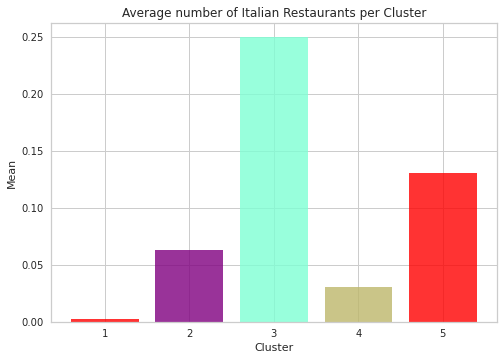

In [121]:

clusters_mean = [df_c1['Italian Restaurant'].mean(),df_c2['Italian Restaurant'].mean(),df_c3['Italian Restaurant'].mean(),
                 df_c4['Italian Restaurant'].mean(),df_c5['Italian Restaurant'].mean()]
objects = (1,2,3,4,5)
y_pos = np.arange(len(objects))
perf = clusters_mean
plt.bar(y_pos, perf, align='center', alpha=0.8, color=['red', 'purple','aquamarine', 'darkkhaki'])
plt.xticks(y_pos, objects)
plt.ylabel('Mean')
plt.xlabel('Cluster')
plt.title('Average number of Italian Restaurants per Cluster')

plt.show()


<b>Cluster 3</b> has most of the Italian Restaurant followed by <b>Cluster 5</b> and <b>Cluster 2</b>